# Прогнозирование спроса
**Краткое описание**:
<br>Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства.
<br>Гранулярность ТК-SKU-День.

**Задача**:
<br>Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

**Метрика качества - `WAPE`**:

```Python
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
```

**Описание данных**

- sales_df_train.csv –данные по продажам за скользящий год для обучения.
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата;
    - pr_sales_type_id – флаг наличия промо;
    - pr_sales_in_units – число проданных товаров всего (промо и без);
    - pr_promo_sales_in_units – число проданных товаров с признаком промо;
    - pr_sales_in_rub – продажи в РУБ всего (промо и без);
    - pr_promo_sales_in_rub – продажи с признаком промо в РУБ;
- pr_df.csv – данные по товарной иерархии.
От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.
    - pr_group_id – захэшированная группа товара;
    - pr_cat_id – захэшированная категория товара;
    - pr_subcat_id – захэшированная подкатегория товара;
    - pr_sku_id – захэшированное id товара;
    - pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).
- pr_st.csv – данные по магазинам.
    - st_id – захэшированное id магазина;
    - st_city_id – захэшированное id города;
    - st_division_code id – захэшированное id дивизиона;
    - st_type_format_id – id формата магазина;
    - st_type_loc_id – id тип локации/окружения магазина;
    - st_type_size_id – id типа размера магазина;
    - st_is_active – флаг активного магазина на данный момент.
- sales_submission.csv – пример файла с результатом работы модели прогноза спроса.
<br>Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями).
    - st_id – захэшированное id магазина;
    - pr_sku_id – захэшированное id товара;
    - date – дата (день);
    - target – спрос в ШТ.

## Setting up the work environment

In [112]:
# !pip install pandas
# !pip install seaborn
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install phik
# !pip install statsmodels
# !pip install scikit-learn
# !pip install category_encoders
# !pip install mlflow

!pip freeze > requirements.txt

  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached docker-7.0.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached entrypoints-0.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached graphene-3.3-py2.py3-none-any.whl.metadata (7.7 kB)
  Using cached importlib_metadata-7.1.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached Markdown-3.6-py3-none-any.whl.metadata (7.0 kB)
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached pyarrow-15.0.2-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl.metadata (559 bytes)
  Using cached sqlparse-0.5.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached itsdange

In [113]:
import os
import random
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import psycopg2 as psycopg
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from statsmodels.tsa.stattools import adfuller
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
# import pickle
# from catboost import CatBoostRegressor, Pool
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import GridSearchCV
# # from sklearn.preprocessing import OrdinalEncoder
# # from sklearn.preprocessing import StandardScaler

os.environ['VIRTUAL_ENV']

'/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta'

Объявление глобальных переменных

In [2]:
HOLIDAYS_PATH = 'data/holidays_covid_calendar.csv'
SALES_PATH = 'data/sales_df_train.csv'
PRODUCTS_PATH = 'data/pr_df.csv'
SHOPS_PATH = 'data/st_df.csv'

ASSETS_DIR = 'assets'
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
TRACKING_SERVER_PORT = 5000
TRACKING_SERVER_HOST = "127.0.0.1"
EXPERIMENT_NAME = 'lenta_demand_forecast'

load_dotenv()
sns.set_style("white")
sns.set_theme(style="whitegrid")
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30

connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}

Импорт класса для проведения исследования

In [3]:
%load_ext autoreload
%autoreload 2

from regression_research_class import DatasetExplorer

## EDA

### sales_df_train

In [5]:
sales_explorer = DatasetExplorer(SALES_PATH)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB

Первые пять строк набора данных:


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0



Количество полных дубликатов строк:


0


Количество пропущенных значений:


st_id                      0
pr_sku_id                  0
date                       0
pr_sales_type_id           0
pr_sales_in_units          0
pr_promo_sales_in_units    0
pr_sales_in_rub            0
pr_promo_sales_in_rub      0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'st_id': 12
Соотношение уникальных значений и общего количества записей в столбце 'st_id': 0.0000
Количество уникальных значений в столбце 'pr_sku_id': 1991
Соотношение уникальных значений и общего количества записей в столбце 'pr_sku_id': 0.0023
Количество уникальных значений в столбце 'pr_sales_type_id': 2
Соотношение уникальных значений и общего количества записей в столбце 'pr_sales_type_id': 0.0000

Описательные статистики целевой переменной:


count    883015.000000
mean          5.037956
std          13.402984
min         -39.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

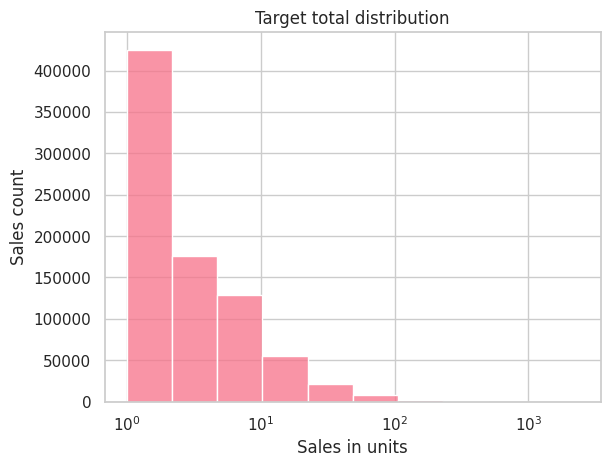

In [6]:
sales_df_train = sales_explorer.explore_dataset(target='pr_sales_in_units', assets_dir=None)

#### Выводы и наблюдения:
- для проведения дальнейшего исследования необходимо преобразование дат;
- пропусков в данных не обнаружено;
- полных дубликатов строк не обнаружено;
- количество уникальных товаров - 1991;
- в целевой переменной имеются отрицательные значения,
  <br>вероятно, это возвраты товаров.

### products_df

In [7]:
products_explorer = DatasetExplorer(PRODUCTS_PATH)

In [9]:
products_df = products_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB

Первые пять строк набора данных:


,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
0,fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
1,71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
2,00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
3,9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
4,3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17



Количество полных дубликатов строк:


0


Количество пропущенных значений:


pr_sku_id       0
pr_group_id     0
pr_cat_id       0
pr_subcat_id    0
pr_uom_id       0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'pr_sku_id': 2050
Соотношение уникальных значений и общего количества записей в столбце 'pr_sku_id': 1.0000
Количество уникальных значений в столбце 'pr_group_id': 9
Соотношение уникальных значений и общего количества записей в столбце 'pr_group_id': 0.0044
Количество уникальных значений в столбце 'pr_cat_id': 43
Соотношение уникальных значений и общего количества записей в столбце 'pr_cat_id': 0.0210
Количество уникальных значений в столбце 'pr_subcat_id': 170
Соотношение уникальных значений и общего количества записей в столбце 'pr_subcat_id': 0.0829
Количество уникальных значений в столбце 'pr_uom_id': 2
Соотношение уникальных значений и общего количества записей в столбце 'pr_uom_id': 0.0010


#### Выводы и наблюдения:
- полных дубликатов строк не обнаружено;
- пропусков в данных не обнаружено.

### shops_df

In [8]:
shops_explorer = DatasetExplorer(SHOPS_PATH)

In [10]:
shops_df = shops_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes

Первые пять строк набора данных:


,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1



Количество полных дубликатов строк:


0


Количество пропущенных значений:


st_id                0
st_city_id           0
st_division_code     0
st_type_format_id    0
st_type_loc_id       0
st_type_size_id      0
st_is_active         0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'st_id': 12
Соотношение уникальных значений и общего количества записей в столбце 'st_id': 1.0000
Количество уникальных значений в столбце 'st_city_id': 7
Соотношение уникальных значений и общего количества записей в столбце 'st_city_id': 0.5833
Количество уникальных значений в столбце 'st_type_format_id': 3
Соотношение уникальных значений и общего количества записей в столбце 'st_type_format_id': 0.2500
Количество уникальных значений в столбце 'st_type_loc_id': 3
Соотношение уникальных значений и общего количества записей в столбце 'st_type_loc_id': 0.2500
Количество уникальных значений в столбце 'st_type_size_id': 6
Соотношение уникальных значений и общего количества записей в столбце 'st_type_size_id': 0.5000


#### Выводы и наблюдения:
- полных дубликатов строк не обнаружено;
- пропущенных значений в данных не обнаружено;
- количество уникальных магазинов - 12

### holiday_df

In [11]:
holiday_explorer = DatasetExplorer(HOLIDAYS_PATH)

In [12]:
holiday_df = holiday_explorer.explore_dataset(target=None, assets_dir=None)

Общая информация по набору данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB

Первые пять строк набора данных:


,year,day,weekday,date,calday,holiday,covid
0,2015,1,4,01.01.2015,20150101,1,0
1,2015,2,5,02.01.2015,20150102,1,0
2,2015,3,6,03.01.2015,20150103,1,0
3,2015,4,7,04.01.2015,20150104,1,0
4,2015,5,1,05.01.2015,20150105,1,0



Количество полных дубликатов строк:


0


Количество пропущенных значений:


year       0
day        0
weekday    0
date       0
calday     0
holiday    0
covid      0
dtype: int64


Процент пропущенных значений в признаках:
Количество уникальных значений в столбце 'holiday': 2
Соотношение уникальных значений и общего количества записей в столбце 'holiday': 0.0005
Количество уникальных значений в столбце 'covid': 2
Соотношение уникальных значений и общего количества записей в столбце 'covid': 0.0005


#### Выводы и наблюдения:
- пропусков не обнаружено;
- повторов строк нет;
- в наборе данных имеются метка принадлежности выходного к covid-19;
- для дальнейшей работы с этим датафреймом необходимо преобразование дат.

### merge_df

In [26]:
holiday_df['date'] = pd.to_datetime(holiday_df['date'], format='%d.%m.%Y')
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'], format='%Y-%m-%d')
main_df = (
    sales_df_train
    .merge(holiday_df[['date', 'holiday', 'covid']], on='date', how='left')
    .merge(shops_df, on='st_id', how='left')
    .merge(products_df, on='pr_sku_id', how='left')
)
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
 8   holiday                  883015 non-null  int64         
 9   covid                    883015 non-null  int64         
 10  st_city_id               883015 non-null  object        
 11  st_division_code         883015 non-null  object        
 12  st_type_format_i

In [27]:
print('Количество записей по активным и неактивным магазинам:')
main_df['st_is_active'].value_counts()

Количество записей по активным и неактивным магазинам:


st_is_active
1    882286
0       729
Name: count, dtype: int64

Вывод:
- количество записей по неактивным магазинам менее 1%,
  <br>принимаю решение данные записи удалить.

In [28]:
main_df = main_df[main_df['st_is_active'] == 1].reset_index(drop=True)

Количество отрицательных и нулевых значений целевой переменной:


66613

Доля отрицательных и нулевых значений целевой переменной в данных:


7.55

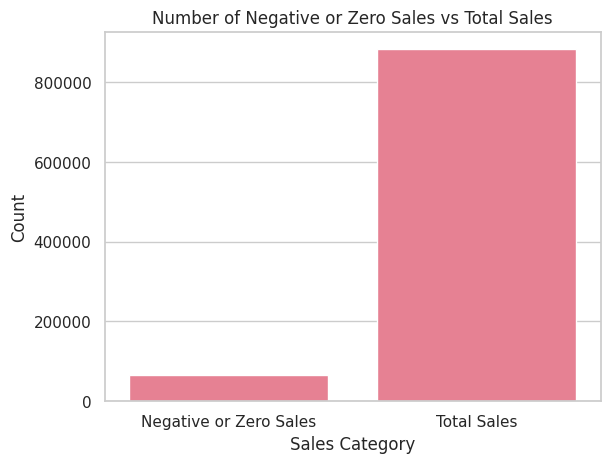

In [16]:
print('Количество отрицательных и нулевых значений целевой переменной:')
display(main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count())
print('Доля отрицательных и нулевых значений целевой переменной в данных:')
display(round((main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count() / main_df['st_id'].count()) * 100, 2))
print()
sales_categories = ['Negative or Zero Sales', 'Total Sales']
sales_counts = [main_df[main_df['pr_sales_in_units'] <= 0]['st_id'].count(), main_df['st_id'].count()]
sns.barplot(x=sales_categories, y=sales_counts)
plt.xlabel('Sales Category')
plt.ylabel('Count')
plt.title('Number of Negative or Zero Sales vs Total Sales')
plt.savefig(os.path.join(ASSETS_DIR, 'Number of Negative or Zero Sales vs Total Sales.png'))
plt.show()

Вывод:
- количество записей по с отрицательными и нулевыми значениями целевой переменной составляет 7.55%,
  <br>принимаю решение данные записи удалить.

In [29]:
main_df = main_df[main_df['pr_sales_in_units'] > 0].reset_index(drop=True)

#### feature analysis

In [35]:
for column in main_df.columns:
    unique_values = main_df[column].nunique()
    print(f"Количество уникальных записей в признаке '{column}': {unique_values}")

Количество уникальных записей в признаке 'st_id': 10
Количество уникальных записей в признаке 'pr_sku_id': 1972
Количество уникальных записей в признаке 'date': 352
Количество уникальных записей в признаке 'pr_sales_type_id': 2
Количество уникальных записей в признаке 'pr_sales_in_units': 378
Количество уникальных записей в признаке 'pr_promo_sales_in_units': 348
Количество уникальных записей в признаке 'pr_sales_in_rub': 12237
Количество уникальных записей в признаке 'pr_promo_sales_in_rub': 10838
Количество уникальных записей в признаке 'holiday': 2
Количество уникальных записей в признаке 'covid': 1
Количество уникальных записей в признаке 'st_city_id': 6
Количество уникальных записей в признаке 'st_division_code': 5
Количество уникальных записей в признаке 'st_type_format_id': 3
Количество уникальных записей в признаке 'st_type_loc_id': 3
Количество уникальных записей в признаке 'st_type_size_id': 5
Количество уникальных записей в признаке 'st_is_active': 1
Количество уникальных за

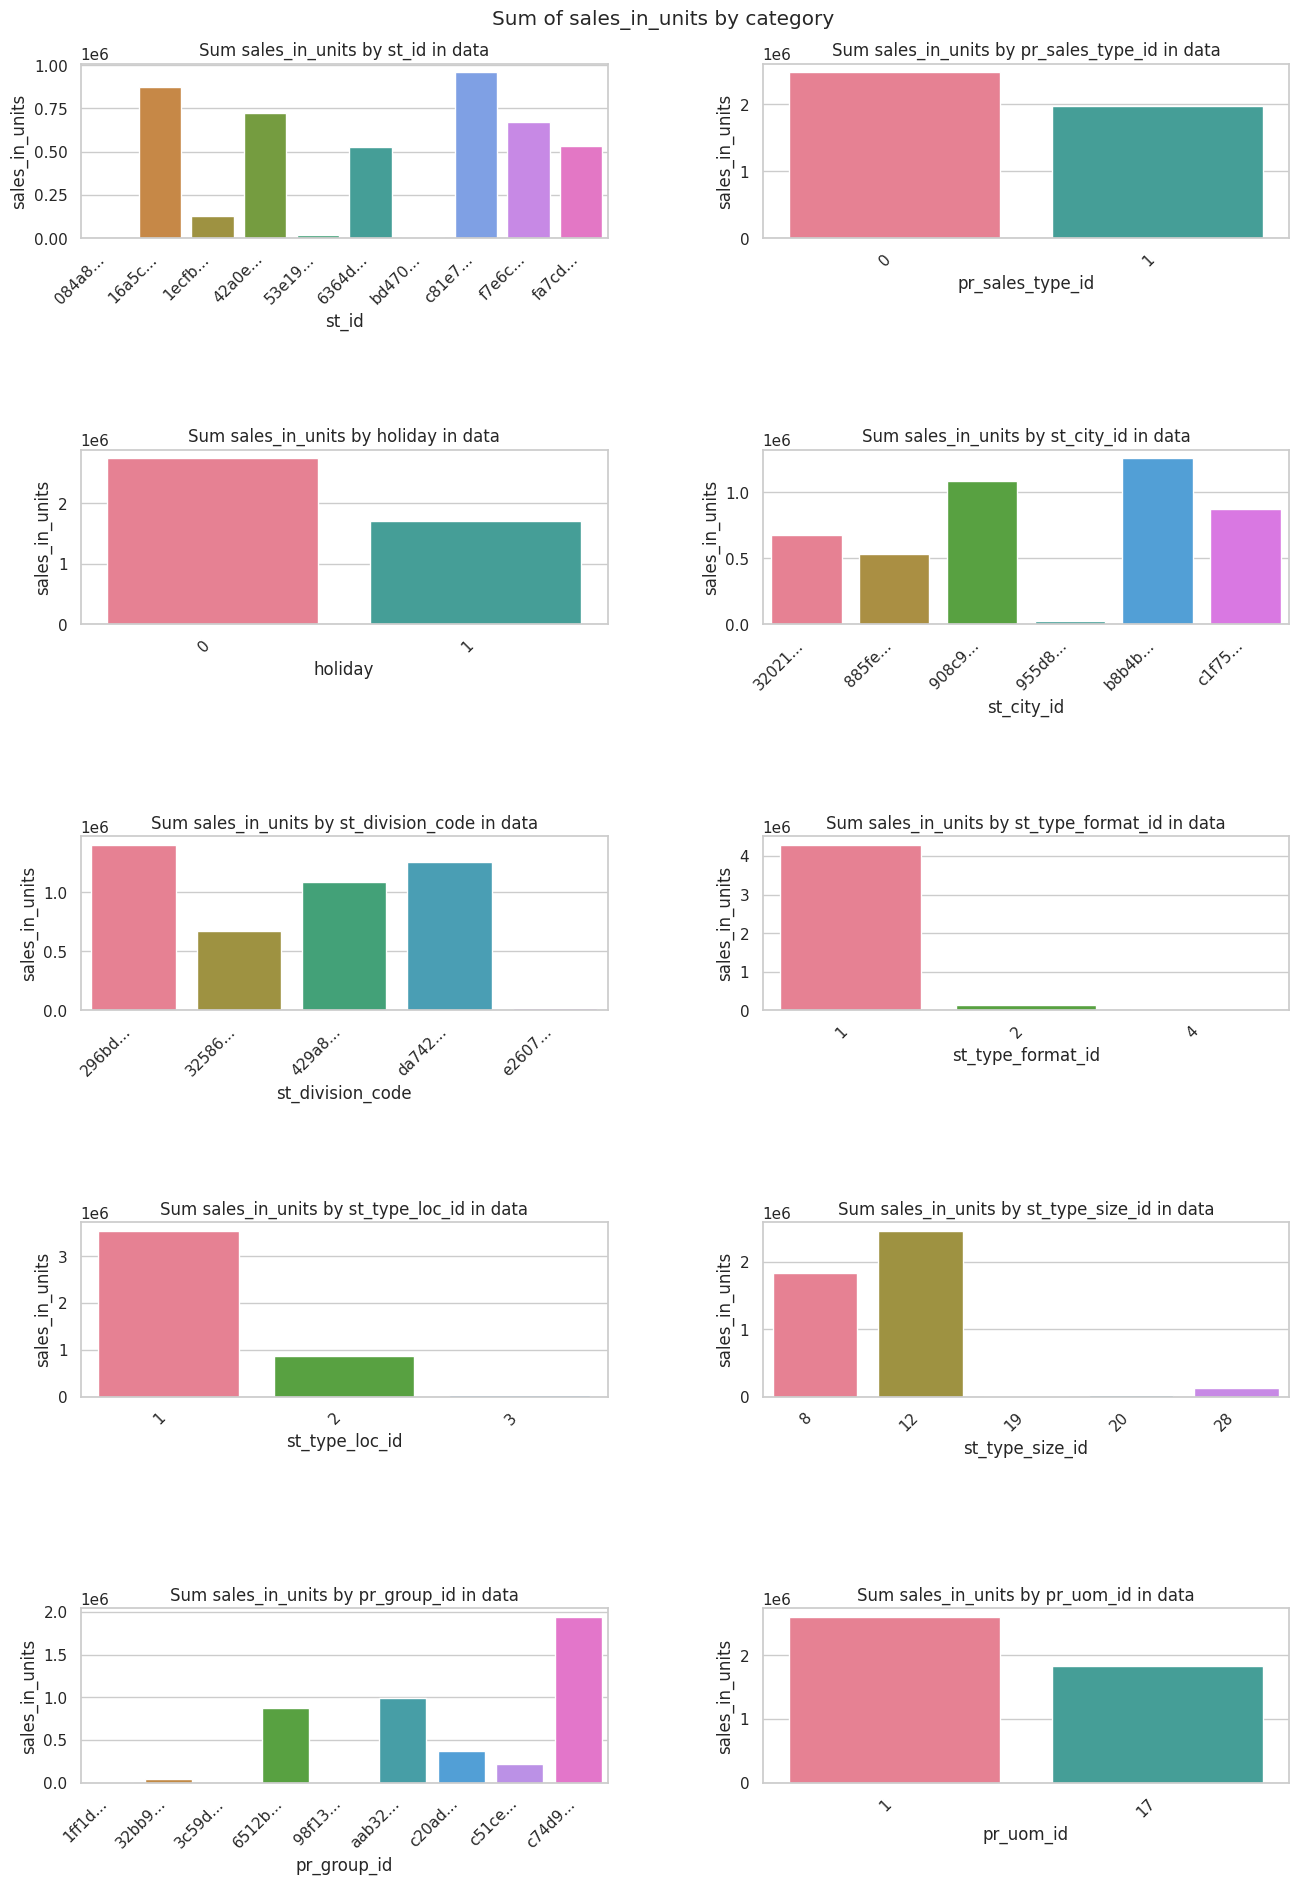

In [57]:
features_for_analysis = ['st_id',
                         'pr_sales_type_id',
                         'holiday',
                         'st_city_id',
                         'st_division_code',
                         'st_type_format_id',
                         'st_type_loc_id',
                         'st_type_size_id',
                         'pr_group_id',
                         'pr_uom_id']

fig, axs = plt.subplots(5, 2)
fig.tight_layout(pad=1.0)
fig.set_size_inches(14, 20, forward=True)

for i, col in enumerate(features_for_analysis):
    agg_df = main_df.groupby(col).agg({'pr_sales_in_units': 'sum'}).reset_index()
    agg_df = agg_df.sort_values(by=col)
    agg_df[col] = agg_df[col].astype(str)
    agg_df[col] = agg_df[col].apply(lambda x: x[:5] + '...' if len(x) > 5 else x)
    sns.barplot(x=col,
                y='pr_sales_in_units',
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Sum sales_in_units by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45, ha='right')
    axs[i // 2, i % 2].set_ylabel('sales_in_units')
fig.suptitle('Sum of sales_in_units by category')
plt.savefig(os.path.join(ASSETS_DIR, 'Sum of sales_in_units by category.png'))
plt.show()

Выводы и наблюдения:
- имеются магазины практически без продаж - возможно, их нужно исключить;
- есть город с практически нулевыми продажами - возможно, его необходимо исключить;
- есть дивизион с практически нулевыми продажами - возможно, его необходимо исключить;
- имеются форматы магазинов практически без продаж - возможно, их нужно исключить;
- имеются товарные группы практически без продаж - возможно, их нужно исключить;
- чтобы принять окончательное решение, необходимо детеальнее рассмотреть каждый параметр.

In [69]:
list_col = ['st_id',
            'st_city_id',
            'st_division_code',
            'st_type_format_id',
            'st_type_loc_id',
            'st_type_size_id',
            'pr_group_id']
for col in list_col:
    print(f'Распределение записей по столбцу ')
    print(main_df[col].value_counts())
    print()

Распределение записей по столбцу 
st_id
c81e728d9d4c2f636f067f89cc14862c    164779
16a5cdae362b8d27a1d8f8c7b78b4330    144017
42a0e188f5033bc65bf8d78622277c4e    128618
f7e6c85504ce6e82442c770f7c8606f0    114286
6364d3f0f495b6ab9dcf8d3b5c6e0b01    105372
fa7cdfad1a5aaf8370ebeda47a1ff1c3    100827
1ecfb463472ec9115b10c292ef8bc986     46219
53e19f3dbb211f20b20b45668303c1b6      9026
bd470ca955d9497bbcb808e59952fffc      2491
084a8a9aa8cced9175bd07bc44998e75        38
Name: count, dtype: int64

Распределение записей по столбцу 
st_city_id
b8b4b727d6f5d1b61fff7be687f7970f    233990
908c9a564a86426585b29f5335b619bc    210998
c1f75cc0f7fe269dd0fd9bd5e24f9586    144017
3202111cf90e7c816a472aaceb72b0df    114324
885fe656777008c335ac96072a45be15    100827
955d864a62659945cc9434898e275deb     11517
Name: count, dtype: int64

Распределение записей по столбцу 
st_division_code
296bd0cc6e735f9d7488ebc8fbc19130    244844
da742b3cfca5388aaf9af28a726a3c30    233990
429a86ff6336c144ddaf6144f52ab52c    

Выводы и наблюдения:
- во всех рассмотрненных признаках имеются значения с совсем небольшим количеством записей,
  <br>но пока их исключать нет необходимости;
- вернуться к ним можно на следующих шагах исследования.

#### target analysis

Описательные статистики целевой переменной:


count    815673.000000
mean          5.451414
std          13.864076
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        2348.000000
Name: pr_sales_in_units, dtype: float64

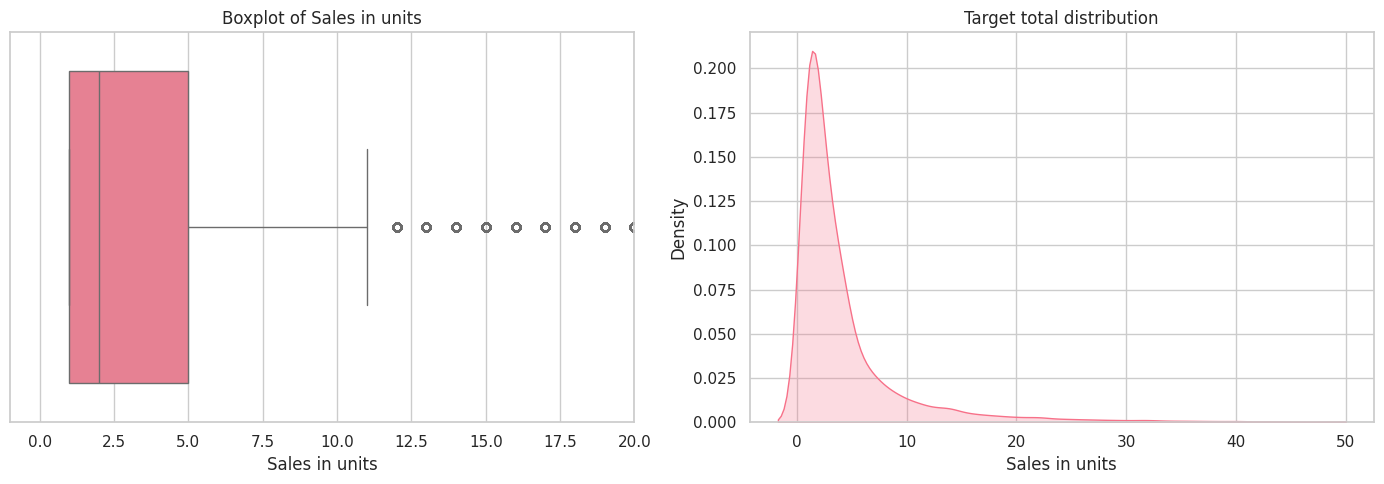

In [85]:
print('Описательные статистики целевой переменной:')
display(main_df['pr_sales_in_units'].describe())
print()

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=main_df, x='pr_sales_in_units', ax=axs[0])
axs[0].set_xlim(-1, 20)
axs[0].set_xlabel('Sales in units')
axs[0].set_title('Boxplot of Sales in units')

sns.kdeplot(data=main_df, x='pr_sales_in_units', clip=(-10, 50), fill=True, ax=axs[1])
axs[1].set_xlabel('Sales in units')
axs[1].set_title('Target total distribution')

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'Target total distribution and boxplot.png'))
plt.show()

Выводы и наблюдения:
- Cреднее значение больше медианного, наблюдается правосторонняя асимметрия;
- распределение целевой переменной `pr_sales_in_units` отличается от нормального.

#### feature correlation matrix

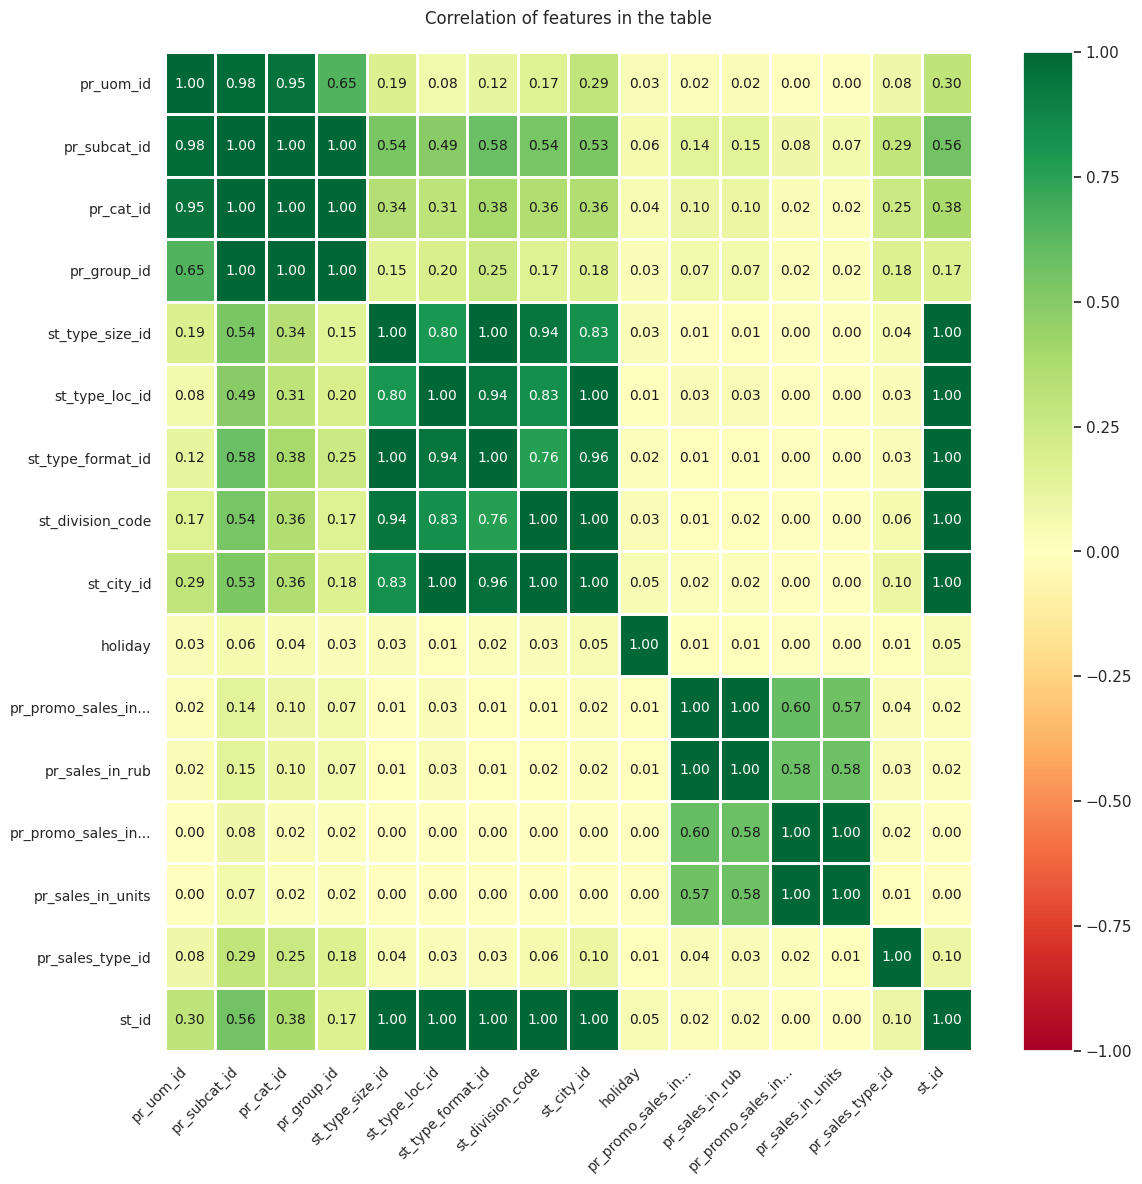

In [18]:
phik_overview = (
    main_df.drop(columns=['pr_sku_id', 'date', 'covid', 'st_is_active'])
    .phik_matrix(interval_cols=main_df.select_dtypes(include=['int', 'float'])))
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(12, 12))
plt.xticks(rotation=45, ha='right')
plt.title(f'Correlation of features in the table', fontsize=12, y=1.02)
plt.savefig(os.path.join(ASSETS_DIR, 'Features correlations.png'))
plt.tight_layout()

Выводы и наблюдения:
- группы признаков, у которых выявлены корреляции:
  - `st_id`, `st_type_size_id`, `st_type_loc_id`, `st_type_format_id`, `st_division_code`, `st_city_id`;
  - `pr_promo_sales_in_units`, `pr_sales_in_units`, `pr_sales_in_rub`, `pr_promo_sales_in_rub`;
  - `pr_uom_id`, `pr_subcat_id`, `pr_cat_id`;
- в каждой группе будет оставлен только один признак.

Удаление неинформативных и коррелированных признаков

In [23]:
clean_df = main_df.copy()
clean_df.drop(['st_is_active',
               'covid',
               'pr_promo_sales_in_units',
               'pr_sales_in_rub',
               'pr_promo_sales_in_rub',
               'pr_subcat_id',
               'pr_cat_id',
               'st_type_size_id',
               'st_type_loc_id',
               'st_type_format_id',
               'st_division_code',
               'st_city_id'],
              axis=1,
              inplace=True)

In [5]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815673 entries, 0 to 815672
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   st_id              815673 non-null  object        
 1   pr_sku_id          815673 non-null  object        
 2   date               815673 non-null  datetime64[ns]
 3   pr_sales_type_id   815673 non-null  int64         
 4   pr_sales_in_units  815673 non-null  float64       
 5   holiday            815673 non-null  int64         
 6   pr_group_id        815673 non-null  object        
 7   pr_uom_id          815673 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 49.8+ MB


### checkpoint_2

In [51]:
# clean_df.to_csv('data/df_1.csv', index=False)
clean_df = pd.read_csv('data/df_1.csv', parse_dates=['date'])

#### distribution of target by date

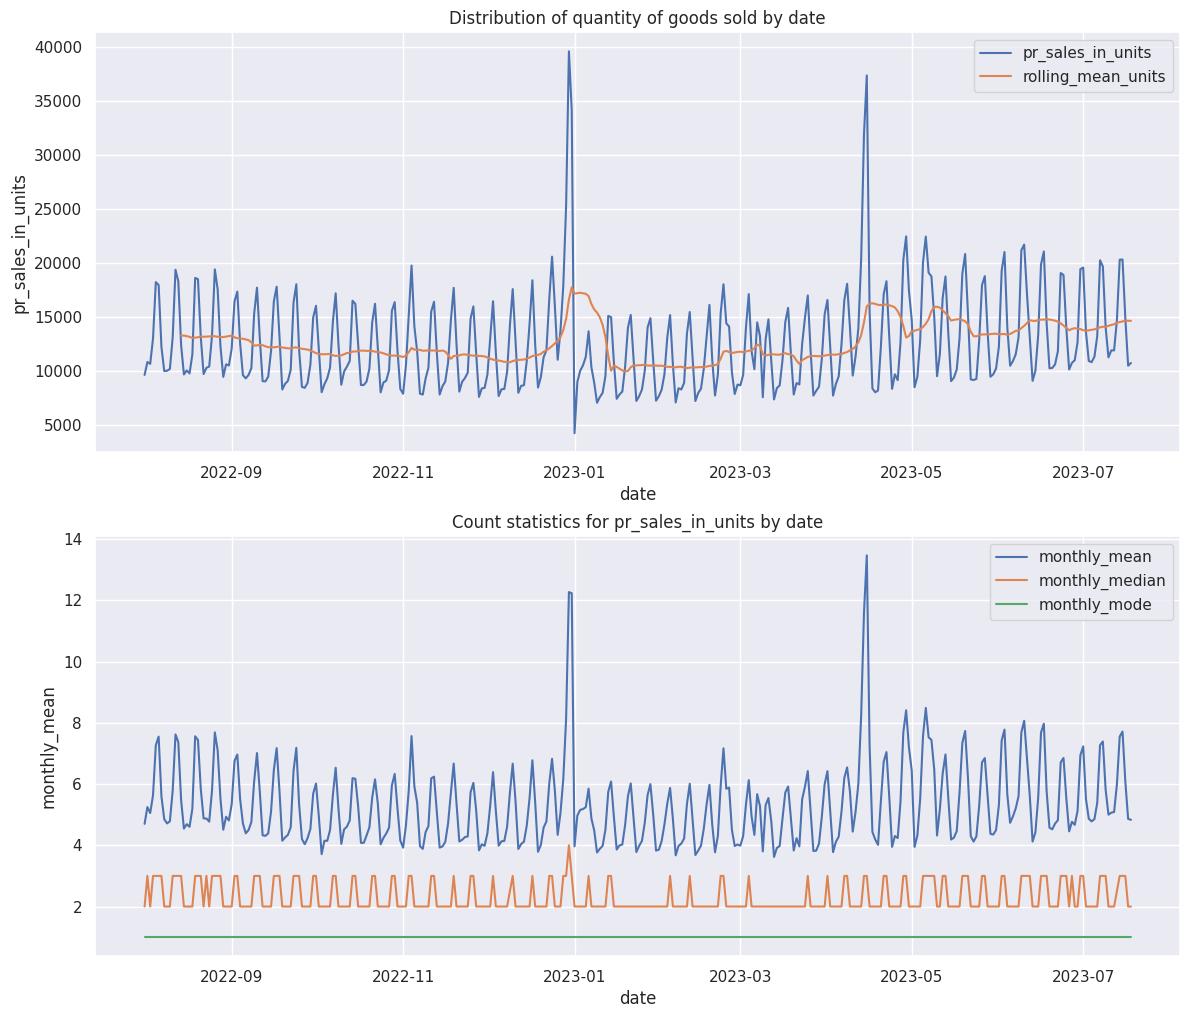

In [28]:
target_agg_by_date = clean_df[['date', 'pr_sales_in_units']].groupby(['date']).agg(['sum']).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = ['date', 'pr_sales_in_units']
target_agg_by_date['rolling_mean_units'] = target_agg_by_date['pr_sales_in_units'].rolling(14).mean()
x = 'date'
sales_columns = ['pr_sales_in_units', 'rolling_mean_units']
stats = ['mean', 'median', lambda x: x.mode().iloc[0]]

sales_monthly_agg = clean_df[[x] + [sales_columns[0]]].groupby([x]).agg(stats).reset_index()
sales_monthly_agg.columns = sales_monthly_agg.columns.droplevel()
sales_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

fig, axs = plt.subplots(2, 1, figsize=(14, 12))

for col in sales_columns:
    sns.lineplot(data=target_agg_by_date, x='date', y=col, label=col, ax=axs[0])
axs[0].set_title('Distribution of quantity of goods sold by date')
axs[0].legend()

for i, stat in enumerate(sales_monthly_agg.columns[1:]):
    sns.lineplot(data=sales_monthly_agg, x=x, y=stat, label=stat, ax=axs[1])
axs[1].set_title(f"Count statistics for {sales_columns[0]} by {x}")
axs[1].legend()

plt.savefig(os.path.join(ASSETS_DIR, 'Target statistics by date.png'))
plt.show()

Выводы и наблюдения:
- самые большие суммарные продажи в конце декабря, начеле января и в апреле,
  <br>это же демонстрирует и скользящее среднее;
- самое низкое значение продаж в начале января;
- медианное значение по месяцам колеблется в интервале от 2-х до 3-х;
- мода - везде равна единице.

#### resampling by sums of values per day

In [52]:
clean_df_dt = clean_df.set_index('date')
clean_df_resamp = clean_df_dt.resample('1D').sum()

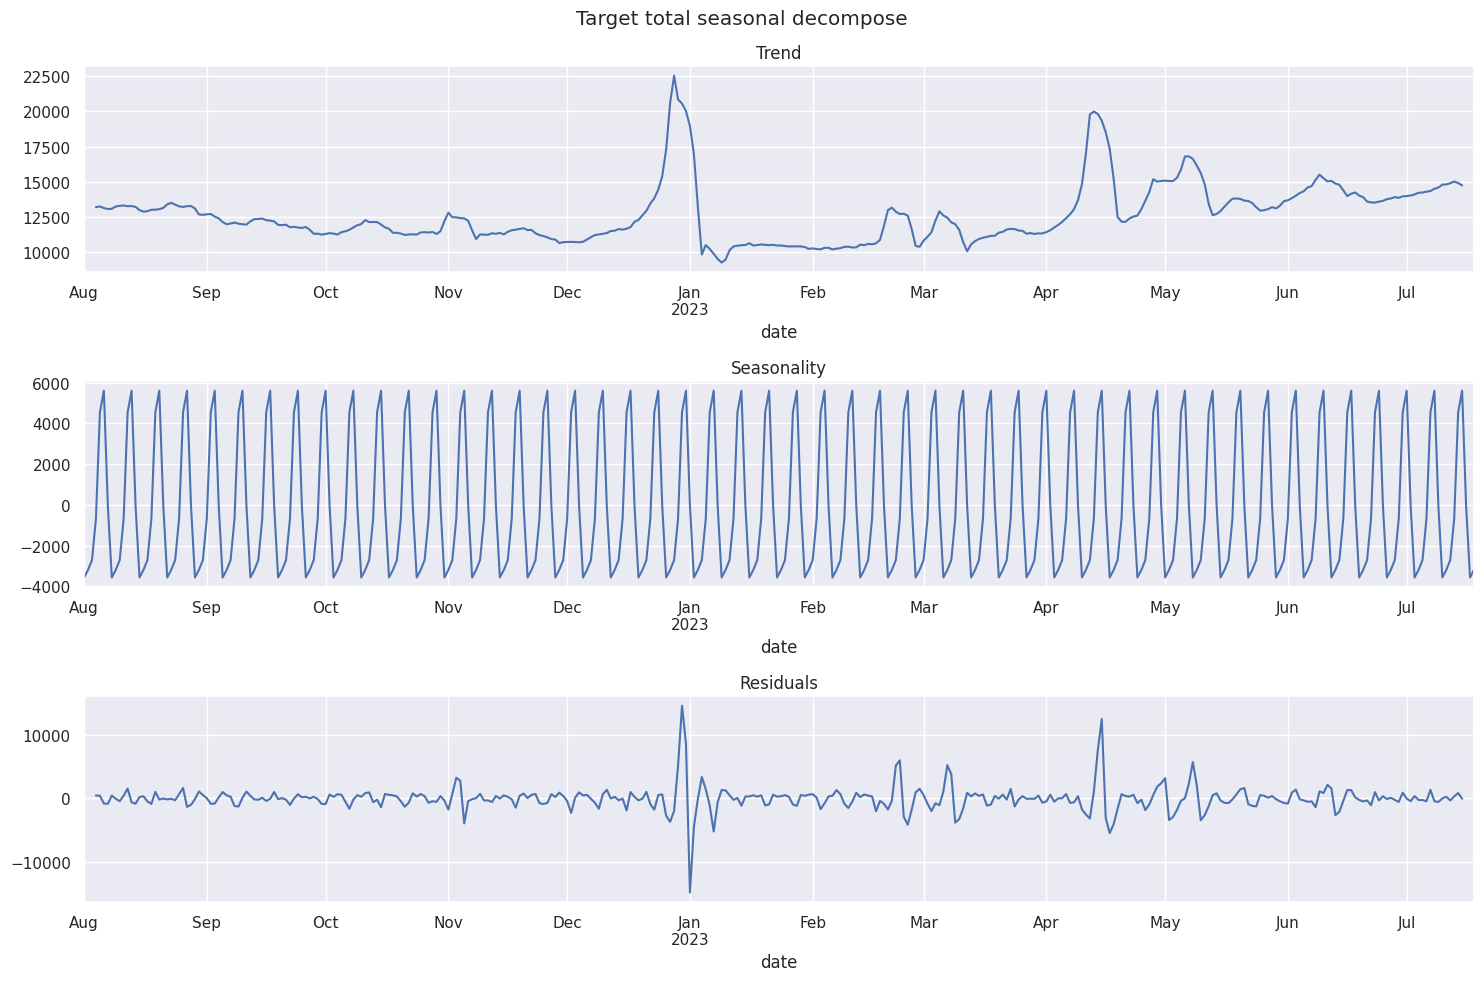

In [61]:
decomposed_units = seasonal_decompose(clean_df_resamp['pr_sales_in_units'])

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed_units.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.suptitle('Target total seasonal decompose')
plt.savefig(os.path.join(ASSETS_DIR, 'Target total seasonal decompose.png'))
plt.tight_layout()
plt.show()

Выводы и наблюдения:
- На графике тренда наблюдается, рост продаж в дни государственных праздников:
  <br>Новый год, 23 февраля, 8 марта, майские праздники, 12 июня - в эти дни образуются локальные пики;
- Самый большой пик продаж в конце декабря, в первые несколько дней января  спрос резко падает.
  <br>Это связано с подготовкой покупателей к корпоративам и празднованию Нового года.
- После первой декады апреля и до начала сентября продажи выше, чем в остальную часть года.
  <br>Это связано с сезоном пикников и  поездками на дачи.

#### study of seasonality over a fortnight interval

In [59]:
fortnight_season = clean_df_resamp['pr_sales_in_units']
fortnight_season = fortnight_season['2023-06-24':'2023-07-11']

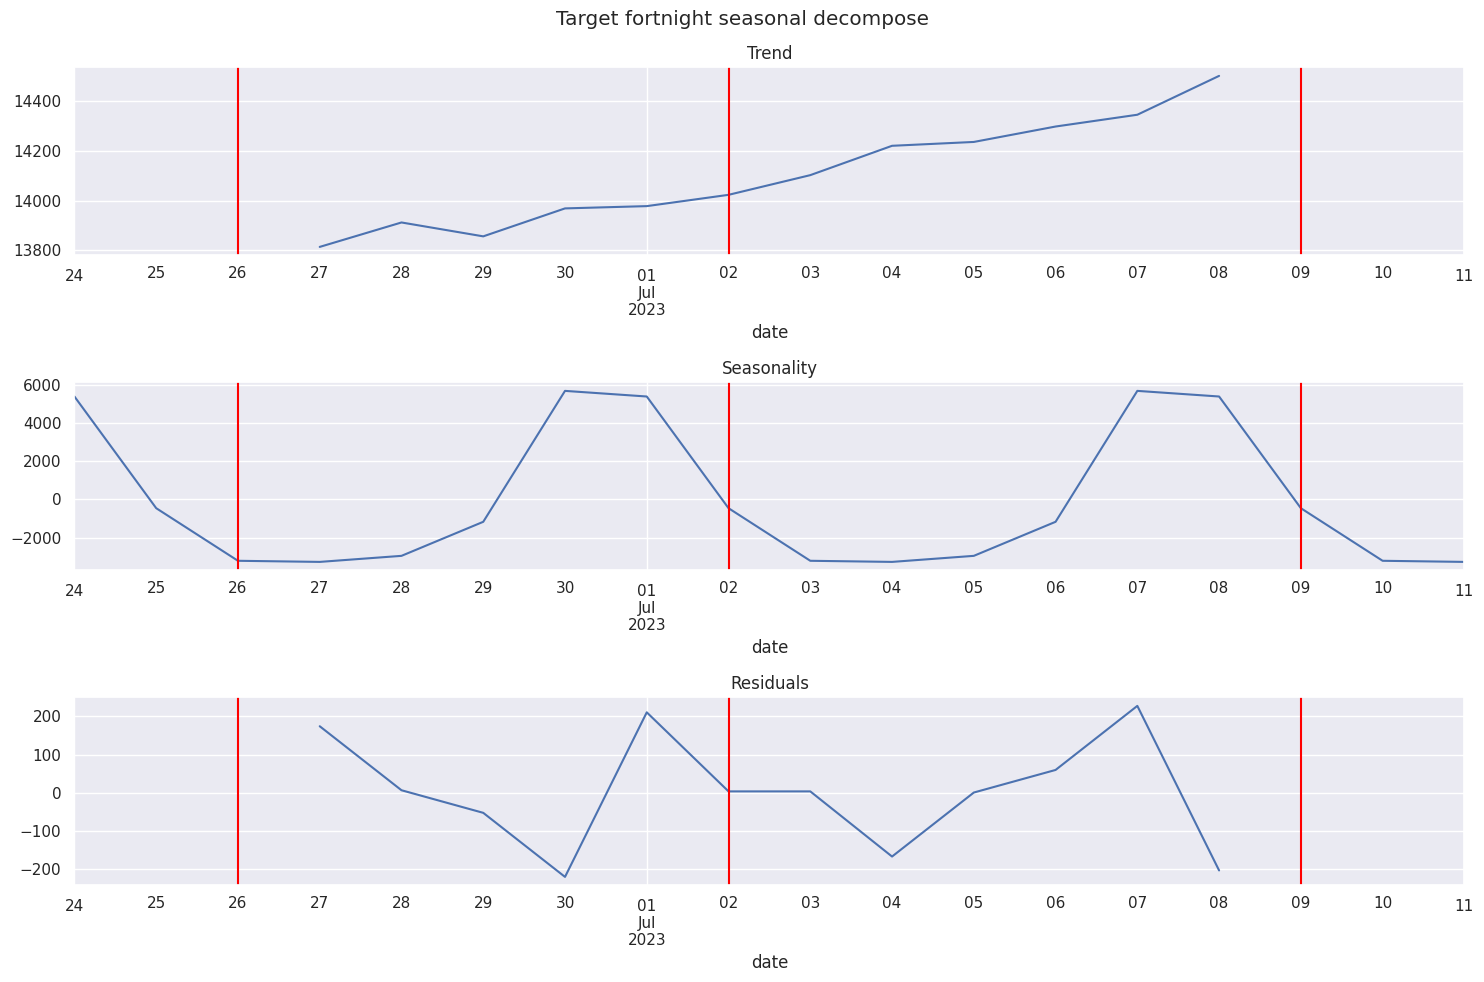

In [63]:
decomposed_week = seasonal_decompose(fortnight_season)

plt.figure(figsize=(15,10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Trend')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Seasonality')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.axvline(x='2023-06-26', color='red', label='axvline - full height')
plt.axvline(x='2023-07-02', color='red', label='axvline - full height')
plt.axvline(x='2023-07-9', color='red', label='axvline - full height')
plt.title('Residuals')

plt.suptitle('Target fortnight seasonal decompose')
plt.savefig(os.path.join(ASSETS_DIR, 'Target fortnight seasonal decompose.png'))
plt.tight_layout()
plt.show()

Выводы и наблюдения:
- При анализе тренда за 2 недели наблюдается, рост продаж в пятницу и субботу,
- в воскресенье отмечается спад.
- Уровень продаж в течение недели ниже, чем в пиковые дни.
- Клиенты чаще совершают покупки перед выходными днями и в выходные.

#### stationarity check

In [66]:
test

(-3.3035023987078924,
 0.014722641217042629,
 14,
 337,
 {'1%': -3.4499043309021955,
  '5%': -2.870154885338925,
  '10%': -2.5713597190254385},
 6156.371021997031)

In [65]:
test = adfuller(clean_df_resamp['pr_sales_in_units'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
  print('есть единичные корни, ряд не стационарен')
else:
  print('единичных корней нет, можем предположить, что ряд стационарен')

adf:  -3.3035023987078924
p-value:  0.014722641217042629
Critical values:  {'1%': -3.4499043309021955, '5%': -2.870154885338925, '10%': -2.5713597190254385}
единичных корней нет, можем предположить, что ряд стационарен


Вывод по тесту Дики-Фуллера:
- Исходя из данного результата теста Дики-Фуллера, можно сделать вывод,
  <br>что временной ряд является стационарным, так как p-значение меньше уровня значимости 0.05,
  <br>и статистика теста меньше критических значений для всех уровней значимости.

### conclusions from the eda
- Данные предоставлены за период с 01.08.2022 по 18.07.2023
- Предоставленные датасеты объединены в один датафрейм
- К общему датафрейму добавлена информация о государственных праздниках и выходных днях в РФ
- Удалены записи по магазинам без маркера активности (действие согласовано с бизнесом): им соответствует 729 записей, что составляет 0.08% датасета.
- Распределение целевой переменной `pr_sales_in_units` отличается от нормального: наблюдается правосторонняя асимметрия
- Удалены данные с нулевыми продажами в шт и руб.
- Удалены записи с отрицательным значением целевого признака (действие согласовано с бизнесом)
- Удалены сильно коррелированные признаки
- Данные разложены на три составляющие (для этого осуществлён ресемплинг по одному дню) - сезонность, тренд и остаток:
  - наблюдается рост спроса перед праздничными днями (годовая сезонность)
  - рост спроса в выходные дни (недельная сезонность)
- Временной ряд может быть стационарен, о чём свидетельствует тест Дики-Фуллера, но наличие тренда и сезонности говорят об обратном

## data_prepare

Объявление метрики

In [108]:
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

In [99]:
clean_df.sort_values(by='date', inplace=True)
clean_df = clean_df.reset_index(drop=True)

X_tmp, X_test, y_tmp, y_test = train_test_split(clean_df.drop(['pr_sku_id', 'date', 'pr_sales_in_units'], axis=1),
                                                clean_df['pr_sales_in_units'],
                                                shuffle=False,
                                                test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_tmp, y_tmp, shuffle=False, test_size=0.111112)

print('Размеры полученных выборок:')
X_train.shape, X_valid.shape, X_test.shape

Размеры полученных выборок:


((652537, 5), (81568, 5), (81568, 5))

Выводы:
- данные разделены на выборки

## baseline

In [111]:
binary_features = X_train.loc[:, X_train.nunique() == 2].columns.to_list()
cat_features = ['st_id', 'pr_group_id']

preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary'), binary_features),
        ('cat', CatBoostEncoder(), cat_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

model = LinearRegression()

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
valid_metrics = {
    'wape': round(wape(y_valid, y_pred), 3),
    'mape': round(mean_absolute_percentage_error(y_valid, y_pred), 3),
    'rmse': round(root_mean_squared_error(y_valid, y_pred), 3),
    'mae': round(mean_absolute_error(y_valid, y_pred), 3),
    'mse': round(mean_squared_error(y_valid, y_pred), 3),
    'r2': round(r2_score(y_valid, y_pred), 3)
}
print('Значения метрик:')
valid_metrics

Значения метрик:


{'wape': 0.891,
 'mape': 1.811,
 'rmse': 12.548,
 'mae': 5.117,
 'mse': 157.442,
 'r2': 0.045}

In [117]:
pip_requirements = 'requirements.txt'
signature = mlflow.models.infer_signature(X_valid, y_pred)
input_example = X_train[:10]
metadata = {"data_used": 'clean_df',
            "library_versions": {"mlflow": "2.12.2",
                                 "category-encoders": "2.6.3",
                                 "scikit-learn":"1.4.2"}
           }
code_paths = ['demand_forecast.ipynb', 'regression_research_class.py']

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = mlflow.set_experiment(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name='baseline_0_registry', experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_params(pipeline.named_steps['model'].get_params())
    mlflow.log_metrics(valid_metrics)
    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline.named_steps['model'],
        artifact_path='artifacts',
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        code_paths=code_paths,
        registered_model_name='baseline',
        await_registration_for=60
		)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
run = mlflow.get_run(run_id)
assert run.info.status == "FINISHED"

/home/denis/Documents/main_venv/demand_forecast_lenta/.venv_lenta/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/05/15 18:53:45 INFO mlflow.tracking.fluent: Experiment with name 'lenta_demand_forecast' does not exist. Creating a new experiment.
Successfully registered model 'baseline'.
2024/05/15 18:

In [118]:
connection.update(postgres_credentials)
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute('''
                    SELECT
                      experiments.name AS experiment_name,
                      runs.name AS run_name,
                      model_versions.name AS model_name,
                      model_versions.version AS model_version,
                      MAX(CASE WHEN metrics.key = 'wape' THEN metrics.value END) AS wape,
                      MAX(CASE WHEN metrics.key = 'mape' THEN metrics.value END) AS mape,
                      MAX(CASE WHEN metrics.key = 'rmse' THEN metrics.value END) AS rmse,
                      MAX(CASE WHEN metrics.key = 'mae' THEN metrics.value END) AS mae,
                      MAX(CASE WHEN metrics.key = 'mse' THEN metrics.value END) AS mse,
                      MAX(CASE WHEN metrics.key = 'r2' THEN metrics.value END) AS r2
                    FROM experiments
                      LEFT JOIN runs USING (experiment_id)
                      LEFT JOIN metrics USING (run_uuid)
                      LEFT JOIN model_versions ON model_versions.run_id=runs.run_uuid
                    WHERE
                      experiments.name = %s
                    GROUP BY
                      experiments.name,
                      runs.name,
                      model_versions.name,
                      model_versions.version
                    ORDER BY wape
                    ''', (EXPERIMENT_NAME,))
        table_data = cur.fetchall()
        table_columns = [desc[0] for desc in cur.description]
        print('Models and their metrics:')
        models_data = pd.DataFrame(table_data, columns=table_columns)
        display(models_data)

Models and their metrics:


,experiment_name,run_name,model_name,model_version,wape,mape,rmse,mae,mse,r2
0,lenta_demand_forecast,baseline_0_registry,baseline,1,0.891,1.811,12.548,5.117,157.442,0.045


Выводы и наблюдения:
- в качестве базовой модели принята модель `LinearRegression`;
- значение метрики на базовой модели: `wape = 0.891`

### Feature engineering

Удаление пропусков и сортировка по дате

In [51]:
total = total.dropna()
total = total.sort_values(by='date')

#### Добавление новых признаков

In [52]:
total_s = total.drop(['pr_sales_in_rub', 'holiday', 'rolling_mean_units', 'rolling_mean_rub'], axis=1)
total_s = total_s.reset_index()
total_s = total_s.groupby(['date', 'st_id',  'pr_sku_id']).sum().reset_index()
total_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614766 entries, 0 to 614765
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               614766 non-null  datetime64[ns]
 1   st_id              614766 non-null  object        
 2   pr_sku_id          614766 non-null  object        
 3   pr_sales_in_units  614766 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 18.8+ MB


Присоединение таблицы `sales_submission` к основному датафрейму

In [53]:
# total_s = total.drop(['pr_sales_in_rub', 'holiday', 'rolling_mean_units', 'rolling_mean_rub'], axis=1)
# total_s = total_s.reset_index()
try:
    sales_submission_s = pd.read_csv('sp_sales_task/sales_submission.csv', parse_dates=['date'])
except:
    sales_submission_s = pd.read_csv('/content/sales_submission.csv', parse_dates=['date'])
sales_submission_s = sales_submission_s.drop(['target'], axis=1)

In [54]:
total_big = pd.concat([total_s, sales_submission_s], axis=0)
total_big =  total_big.merge(holiday, on='date', how='left')
total_big = total_big.sort_values(by='date')
total_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658460 entries, 0 to 658459
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               658460 non-null  datetime64[ns]
 1   st_id              658460 non-null  object        
 2   pr_sku_id          658460 non-null  object        
 3   pr_sales_in_units  614766 non-null  float64       
 4   holiday            658460 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 30.1+ MB


In [55]:
tb_sku_sorted = total_big.sort_values(['pr_sku_id', 'date'])
tb_sku_sorted.head()

,date,st_id,pr_sku_id,pr_sales_in_units,holiday
391261,2023-03-16,6364d3f0f495b6ab9dcf8d3b5c6e0b01,002c3a40ac50dc870f1ff386f11f5bae,1.0,0
603807,2023-07-13,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,1.0,0
606719,2023-07-14,c81e728d9d4c2f636f067f89cc14862c,0045ebdb1069ff4b3dd3efe628c39cd3,2.0,0
605654,2023-07-14,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2.0,0
608675,2023-07-15,c81e728d9d4c2f636f067f89cc14862c,0045ebdb1069ff4b3dd3efe628c39cd3,1.0,1


Функция для создания дополнительных признаков

In [56]:
#len(sales_submission_s.groupby(['st_id', 'pr_sku_id'])['date'])
def create_features(data, window, max_lag):

  try:
        data['day'] = data['date'].dt.day
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['weekday'] = data['date'].dt.weekday

        # Сортируем данные по столбцам st_id, pr_sku_id и date
        data = data.sort_values(by=['st_id', 'pr_sku_id', 'date'])

        # Группируем данные по столбцах st_id и pr_sku_id
        grouped_data = data.groupby(['st_id', 'pr_sku_id'])

        # Вычисляем скользящее среднее значение pr_sales_in_units для каждой группы
        data['rolling_average'] = (
            grouped_data['pr_sales_in_units']
            .rolling(window=window, min_periods=1)
            .mean()
            .reset_index(drop=True)
            )

        # Добавляем смещение на 14 дней к столбцу rolling_average
        #data['rolling_average'] = data.groupby(['st_id', 'pr_sku_id'])['rolling_average'].shift(max_lag) код для одного столбца

        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data.groupby(['st_id', 'pr_sku_id'])['rolling_average'].shift(lag, fill_value=0)

        # Создаем столбец с lag значениями pr_sales_in_units
        data['lag_pr_sales_in_units'] = grouped_data['pr_sales_in_units'].shift(max_lag, fill_value=0)
  except ValueError:
        print("Oops!  That was no valid number.  Try again...")
  return data

Применение функции к датафрейму

In [57]:
data = create_features(tb_sku_sorted, 3, 14)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658460 entries, 428974 to 293851
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   658460 non-null  datetime64[ns]
 1   st_id                  658460 non-null  object        
 2   pr_sku_id              658460 non-null  object        
 3   pr_sales_in_units      614766 non-null  float64       
 4   holiday                658460 non-null  int64         
 5   day                    658460 non-null  int64         
 6   month                  658460 non-null  int64         
 7   year                   658460 non-null  int64         
 8   weekday                658460 non-null  int64         
 9   rolling_average        620752 non-null  float64       
 10  lag_1                  621208 non-null  float64       
 11  lag_2                  621556 non-null  float64       
 12  lag_3                  621881 non-null 

In [58]:
data = data.fillna(0)
data = data.sort_values(by='date')

Разделение датафреймов

In [59]:
total = data.loc[(data['date'] <= total_s['date'].max()) & (data['date'] >= total_s['date'].min())]
total = total.set_index('date')

Вывод: добавлены новые признаки к датафрейму

#### Выделение категориальных и количественных признаков

In [60]:
RS = 42
#num_features = ['holiday', 'rolling_mean_units', 'rolling_mean_rub', 'day', 'month', 'year', 'weekday']
cat_features = ['st_id', 'pr_sku_id']

Выделены категориальные признаки, установлен `random state`

#### Разделение данных на обучающую и тестовую выборки

In [61]:
X = total.drop(['pr_sales_in_units'], axis=1)
y = total['pr_sales_in_units']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((553289, 23), (61477, 23), (553289,), (61477,))

Выделен целевой признак, удалены признаки с большим количеством уникальных значений (вынужденная мера в целях сохранения производительности)

#### Применение `OneHotEncoder` и `StandardScaler`

Использование техник кодирования и масштабирования, чтобы привести данные к виду, подходящему для обучения линейной модели

In [63]:
def data_encoding(X_train, X_test):
    encoder = OrdinalEncoder()
    encoder.fit(X_train[cat_features])

    # X_train_oe = pd.DataFrame(encoder.transform(X_train[cat_features]), columns=cat_features, index=X_train.index)
    # X_train_oe = X_train_oe.merge(X_train.drop(cat_features, axis=1), how='left', left_index=True, right_index=True, sort=False)
    # X_test_oe = pd.DataFrame(encoder.transform(X_test[cat_features]), columns=cat_features, index=X_test.index)
    # X_test_oe = X_test_oe.merge(X_test.drop(cat_features, axis=1), how='left', left_index=True, right_index=True, sort=False)

    # scaler = StandardScaler()
    # scaler.fit(X_train[num_features])

    # X_train_sc = pd.DataFrame(scaler.transform(X_train[num_features]), columns=num_features, index=X_train.index)
    # X_test_sc = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index)

    # X_train_enc = X_train_oe.merge(X_train_sc, how='left', left_index=True, right_index=True, sort=False)
    # X_test_enc = X_test_oe.merge(X_test_sc, how='left', left_index=True, right_index=True, sort=False)

    return X_train_sc, X_test_sc

In [64]:
# X_train_enc, X_test_enc = data_encoding(X_train, X_test)
# X_train_enc.shape, X_test_enc.shape

При попытке кодирования данных происходит падение ядра. Проведение операции на данном этапе осложнено

### Modeling

#### Кросс-валидатор временных рядов

In [65]:
tscv = TimeSeriesSplit(n_splits=round((X_train.shape[0] / X_test.shape[0]) - 1))

#### Метрика для определения качества модели

In [66]:
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

#### Модель `LinearRegression`

In [ ]:
# model_lr = LinearRegression()

# param_lr = {}#'fit_intercept': [True, False], 'normalize': [True, False]}

# lr_gs = GridSearchCV(estimator=model_lr, param_grid=param_lr, cv=tscv, scoring=make_scorer(wape, greater_is_better=False))

# lr_gs.fit(X_train, y_train)
# display('Параметры лучшей модели', lr_gs.best_params_)
# display('Показатель wape лучшей модели', lr_gs.best_score_*(-1))

#### Модель `CatBoostRegressor`

In [ ]:
params_cb = (
    {'depth':[7], #[1, 3], [3, 5], [5, 7]
     'l2_leaf_reg': [5], #[1, 3], [3, 5], [5, 7]
     'learning_rate': [0.03], #(0.1, 0.2), (0.05, 0.1), np.arange(0.03, 0.05)
     'iterations': [700]} #n_estimators[100, 300], [300, 500], [500, 700]
    )
model_cbr = CatBoostRegressor(params_cb, random_state=RS, verbose=100)
# model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=2, learning_rate=0.01, iterations=1000, random_state=RS, verbose=100)

# model_cbr.fit(X_train, y_train, cat_features=cat_features)
# cbc_gs = model_cbc.grid_search(params_cb, Pool(X_train, y_train, cat_features=cat_features), cv=tscv, verbose=100)
# display('Лучшие параметры:', model_cbc.get_params())

cbc_gs = GridSearchCV(model_cbr, params_cb, n_jobs=-1, scoring=make_scorer(wape, greater_is_better=False), cv=tscv)
cbc_gs.fit(X_train, y_train, cat_features=cat_features)
display('Параметры лучшей модели', cbc_gs.best_params_)
display('Показатель wape лучшей модели', cbc_gs.best_score_*(-1)) #0.68, 0.676

0:	learn: 16.0810690	total: 1.05s	remaining: 12m 14s
100:	learn: 12.0891907	total: 41.5s	remaining: 4m 5s
200:	learn: 11.4770135	total: 1m 18s	remaining: 3m 15s
300:	learn: 11.0207913	total: 1m 58s	remaining: 2m 36s
400:	learn: 10.6974900	total: 2m 37s	remaining: 1m 57s
500:	learn: 10.4889966	total: 3m 17s	remaining: 1m 18s
600:	learn: 10.3078562	total: 4m 1s	remaining: 39.8s
699:	learn: 10.1713723	total: 4m 40s	remaining: 0us


'Параметры лучшей модели'

{'depth': 7, 'iterations': 700, 'l2_leaf_reg': 5, 'learning_rate': 0.03}

'Показатель wape лучшей модели'

0.5103740933775973

#### Проверка по метрике качества на тестовых данных

In [ ]:
'Показатель wape лучшей модели на тестовой выборке', wape(y_test, model_cbr.predict(X_test)) #wape(y_test, cbc_gs.predict(X_test)

('Показатель wape лучшей модели на тестовой выборке', 0.48316615497259535)

Диаграмма сравнения предсказаний с реальными данными

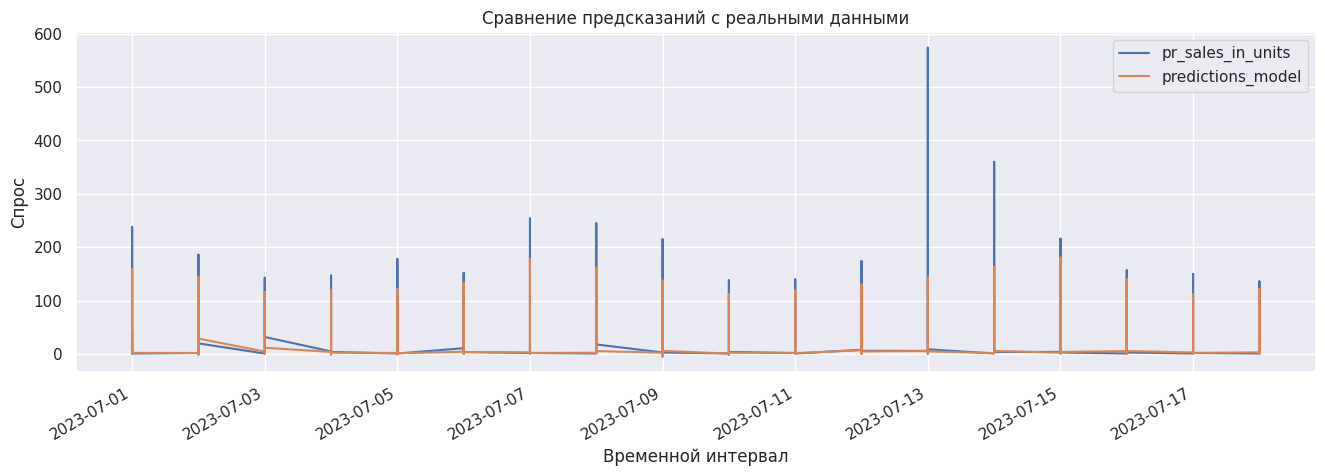

In [ ]:
predictions_model = pd.Series(data = cbc_gs.predict(X_test), name = 'predictions_model', index = X_test.index)

y_test['2023-07-01':'2023-07-31'].plot(figsize=(16,5), grid=True, legend=True)
predictions_model['2023-07-01':'2023-07-31'].plot(grid=True, legend=True)
plt.title('Сравнение предсказаний с реальными данными')
plt.xlabel('Временной интервал')
plt.ylabel('Спрос')
#plt.kind(barplot)
plt.show()

#### Feature importance

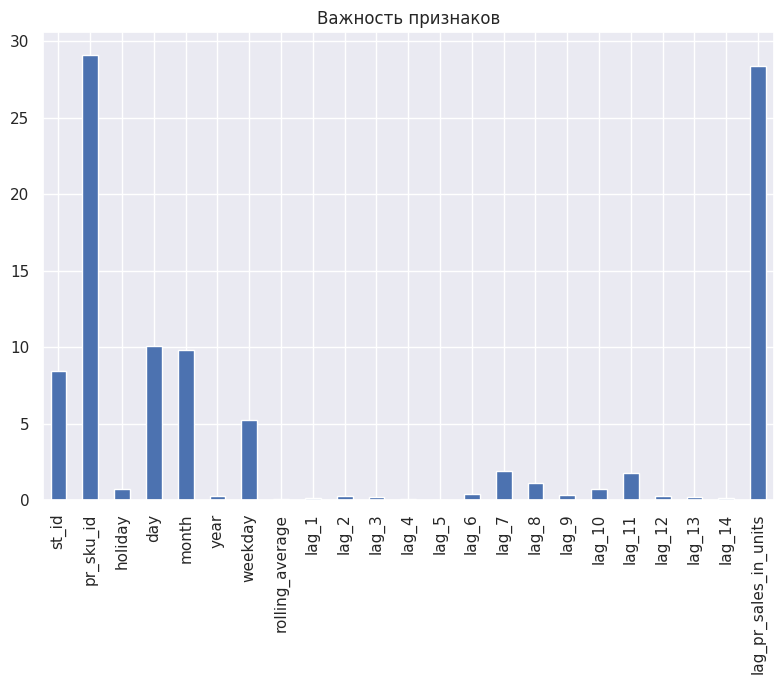

In [ ]:
cbr_fi = pd.Series(cbc_gs.best_estimator_.feature_importances_, X.columns)
fig, ax = plt.subplots(figsize=(8,7))
cbr_fi.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

#### Получение предсказания на следующие две недели

Обучение модели с выбранными параметрами на полном датасете

In [74]:
model_cbr = CatBoostRegressor(depth=7, l2_leaf_reg=5, learning_rate=0.03, n_estimators=700, random_state=RS, verbose=100)
model_cbr.fit(X, y, cat_features=cat_features)

0:	learn: 15.6825277	total: 634ms	remaining: 7m 23s
100:	learn: 12.2570184	total: 42.5s	remaining: 4m 11s
200:	learn: 11.6273114	total: 1m 23s	remaining: 3m 28s
300:	learn: 11.1906155	total: 2m 1s	remaining: 2m 41s
400:	learn: 10.8305776	total: 2m 44s	remaining: 2m 2s
500:	learn: 10.5692663	total: 3m 25s	remaining: 1m 21s
600:	learn: 10.3707171	total: 4m 13s	remaining: 41.7s
699:	learn: 10.2195330	total: 4m 52s	remaining: 0us


Открытие файла, установка даты индексом

In [75]:
sales_submission_s = data.loc[(data['date'] > total_s['date'].max())]
sales_submission_s = sales_submission_s.drop(['pr_sales_in_units'], axis=1)
sales_submission_s = sales_submission_s.set_index('date')
sales_submission_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43694 entries, 2023-07-19 to 2023-08-01
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   st_id                  43694 non-null  object 
 1   pr_sku_id              43694 non-null  object 
 2   holiday                43694 non-null  int64  
 3   day                    43694 non-null  int64  
 4   month                  43694 non-null  int64  
 5   year                   43694 non-null  int64  
 6   weekday                43694 non-null  int64  
 7   rolling_average        43694 non-null  float64
 8   lag_1                  43694 non-null  float64
 9   lag_2                  43694 non-null  float64
 10  lag_3                  43694 non-null  float64
 11  lag_4                  43694 non-null  float64
 12  lag_5                  43694 non-null  float64
 13  lag_6                  43694 non-null  float64
 14  lag_7                  43694 non-null

Добавление предсказаний в таблицу, удаление ненужных признаков

In [77]:
sales_submission_s['target'] = model_cbr.predict(sales_submission_s)
sales_submission_s['target'] = round(sales_submission_s['target'], 0)
sales_submission_s = sales_submission_s.reset_index()
sales_submission_s = sales_submission_s.drop(['holiday', 'day', 'month', 'year', 'weekday'], axis=1)
sales_submission_s = sales_submission_s[['st_id', 'pr_sku_id', 'date', 'target']]
sales_submission_s.head()

,st_id,pr_sku_id,date,target
0,6364d3f0f495b6ab9dcf8d3b5c6e0b01,72740338e91de3ccc276b9bc7681bd0d,2023-07-19,1.0
1,6364d3f0f495b6ab9dcf8d3b5c6e0b01,e6449990bb6a761a964e58dd95f7a479,2023-07-19,2.0
2,42a0e188f5033bc65bf8d78622277c4e,4ba72d594b35e41cb3e066397eecdfba,2023-07-19,3.0
3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,3bb2524fb92c7c5fec7a4223e4fadf68,2023-07-19,1.0
4,c81e728d9d4c2f636f067f89cc14862c,b43e19936412e99b8efd1f9061d3f3c7,2023-07-19,5.0


#### Сохранение результатов

Сохранение результата предсказания

In [78]:
sales_submission_s.to_csv('sales_submission_pred.csv', encoding='utf-8')

Запись модели в файл

In [79]:
with open('model_cbr.pkl', 'wb') as f:
  pickle.dump(model_cbr, f)

### Заключение

- Предоставленные данные объединены в единый датафрейм, к ним присоединена информация о праздничных и выходных днях в РФ
- Проведено исследование на корреляцию в признаках, удалены зависимые признаки
- Проведено исследование на сезонность и тренд
- Добавлены синтетические признаки (лаги, даты, скользящее среднее)
- Возникли проблемы при попытке применения техник кодирования, в связи с чем из исследования исключены простые модели ML: линейная регрессия, случайный лес, дерево решений
- Для запуска `ARIMA` недостаточно ресурсов
- Для прогнозирования применена модель градиентного бустинга, т.к. она может одинаково хорошо работает с категориальными и количественными признаками
- При помощи `GridSearch` подобраны оптимальные параметры модели с показателем `wape` на трейне 0.51
- На тестовой выборке показатель `wape` получен 0.48
- Анализ значимости признаков показал, что наиболее важный признак - `lag_pr_sales_in_units` и `pr_sku_id`
- Конечная модель обучена на полном наборе данных